[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cyneuro/Fear-Lesson-Plans/blob/master/Lesson-1-What-is-Fear/What-is-Fear.ipynb)

To run this and other Colab notebooks on the browser, click on "Open in Colab" at the top, and then once it is opened in the browser, to the menu at the time, select "Runtime" and then select "Run all". This will run all the code in the notebook. Note that this is a self-learning modules with text, video and other materials, interspersed with code, to enable the user to both understand the concepts in parallel with having Colab run the code
## 1-Cell Amygdala Salivation Model
## Before we get into 'what is fear', we will be talking about a famous example of conditioning with Pavlov's dogs. View the video below detailing the experiment.
*   ### STEP 1. The neurons in amygdala of dogs (and humans) fire very low normally, e.g., 0.1-0.5 Hz. However, in the state of salivation, they fire at a high rate, e.g., 5 Hz.
*   ### STEP 2. In the Pavlovian bell salivation conditioning paradigm (that is covered in the powerpoint and video), the neural pathway carrying the bell information to the amygdala strengthens with repeated conditioning. That is, the synaptic strength (weight) of the connection increases till the bell itself is capable of firing the amygdala(and causing salivation)
*   ### STEP 3. You are given a model of an amygdala neuron, with knobs to change the following: (i) synaptic strength of the connection, (ii) delay from start when the bell begins, and (iii) the duration of the bell.         NOTE: only the first parameter, (i), is changed this version of the code.

## The model being used:

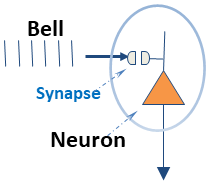

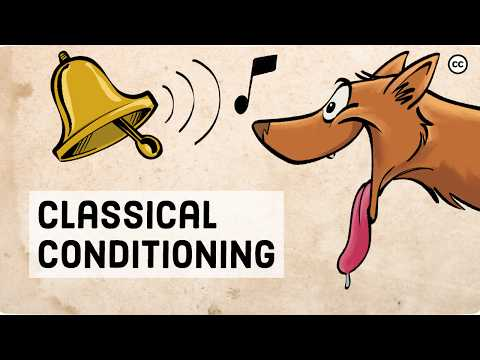

In [1]:
#@title Run cell to load video

from IPython.display import YouTubeVideo
YouTubeVideo('jd7Jdug5SRc')

---
### CHALLENGE - Assume the baseline firing rate, i.e., in the absence of salivation is **0.5 Hz**. And that the firing rate when salivating is **5 Hz**. Your task is to manipulate the value of the 'input strength' (strength of tone or bell connection) below to find the settings that results in a NO-SALIVATION state, and the SALIVATION state.  Report the tone strength values you found for the two cases. 

In [2]:
#@title download files
import os
RunningInCOLAB = 'google.colab' in str(get_ipython())  # checks to see if we are in google colab
if RunningInCOLAB:                                     # installs packages and repo if in colab
    !pip install ipywidgets &> /dev/null
    !pip install neuron &> /dev/null
    !pip install bmtk &> /dev/null

    !git clone https://github.com/cyneuro/Fear-Lesson-Plans &> /dev/null
    %cd Fear-Lesson-Plans/Lesson-1-What-is-Fear/

if(os.path.exists('x86_64')==False):
    os.system('nrnivmodl modfiles')

In [3]:
#@title run model
from neuron import h
from neuron.units import ms, mV
import matplotlib.pyplot as plt
import numpy as np
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
import ipywidgets as widgets
from IPython.display import display, clear_output

seed = 1234
rng = np.random.default_rng(seed)
np.random.seed(seed)

def generate_poisson_spikes(syn_number, start_time, end_time, hz):
    spikes = PoissonSpikeGenerator(population='spikes')
    spikes.add(node_ids=range(syn_number), firing_rate=hz, times=(start_time, end_time))
    return spikes

def run_model(b):
    clear_output()
    print("Running Model!")
    PN_weight_val = PN_weight_slider.value
    display(controls_box)
    model(PN_weight=PN_weight_val, PV_weight=1)

def model(PN_weight=None, PV_weight=None):
    seed = 1234
    rng = np.random.default_rng(seed)
    np.random.seed(seed)
    h.load_file('stdrun.hoc')
    h.load_file('PN_cells.hoc')  # reads in template
    cell = h.PN_C()  # cell from template file

    h.dt = 0.1  # time step (resolution) of the simulation in ms
    h.tstop = 5000  # how long to run the simulation in ms
    h.v_init = -65  # initial membrane potential in mV

    exc_syn_num = 23  # from amygdala paper
    inh_syn_num = 43  # from amygdala paper

    PN_spikes = generate_poisson_spikes(exc_syn_num, start_time=0.5, end_time=5, hz=10)
    PV_spikes = generate_poisson_spikes(inh_syn_num, start_time=0.5, end_time=5, hz=5)

    for i in range(exc_syn_num):  # for every excitatory synapse(PN2PN):
        conn_exc = h.AMPA_NMDA_STP(cell.dend[0](0.9))  # create syn on apical dendrite
        conn_exc.e = 0
        spikes_exc = PN_spikes.get_times(node_id=i)  # original version of creating spike trains
        v_spikes_exc = h.Vector(spikes_exc)  # make vector based on the spike train
        vec_stim_exc = h.VecStim()  # have vecstim play it
        vec_stim_exc.play(v_spikes_exc)
        nc_exc = h.NetCon(vec_stim_exc, conn_exc, 1, 1, PN_weight)

    for i in range(inh_syn_num):
        conn_inh = h.Exp2Syn(cell.dend[0](0.5))
        conn_inh.e = -75
        spikes_inh = PV_spikes.get_times(node_id=i)
        v_spikes_inh = h.Vector(spikes_inh)
        vec_stim_inh = h.VecStim()
        vec_stim_inh.play(v_spikes_inh)
        nc_exc2 = h.NetCon(vec_stim_inh, conn_inh, 1, 1, PV_weight)

    # Setup recording of spike times
    spike_times = h.Vector()
    spike_detector = h.NetCon(cell.soma[0](0.5)._ref_v, None, sec=cell.soma[0])
    # Set the voltage threshold for spike detection
    spike_detector.threshold = -15  # Set the threshold to -15 mV
    spike_detector.record(spike_times)

    t = h.Vector()  # Vectors are used to record data in the simulation
    Soma_v = h.Vector()

    t.record(h._ref_t)  # dereferences and records data
    Soma_v.record(cell.soma[0](0.5)._ref_v)

    h.finitialize(h.v_init * mV)  # runs sims
    h.continuerun(h.tstop * ms)

    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 8))

    # Convert spike times to a NumPy array
    try:
        spike_times_array = np.array(spike_times)
    except:
        spike_times_array = np.zeros(1)

    # Calculate number of spikes
    num_spikes = len(spike_times_array)

    # Calculate firing rate (spikes per second)
    if h.tstop > 0:
        firing_rate = round(num_spikes / (4500 / 1000),3)  # Convert to seconds
    else:
        firing_rate = 0.0

    # Print results
    print("Number of spikes:", num_spikes)
    print("Firing rate:", firing_rate, "Hz")

    ax.plot(t, Soma_v)
    plt.show()

# Create sliders
PN_weight_slider = widgets.FloatSlider(value=2.5, min=2.5, max=100.0, step=1, description='Input Strength:',style=dict(description_width='initial'))

# Create Run button
run_button = widgets.Button(description="Run")
run_button.on_click(run_model)

# Arrange widgets using HBox and VBox
slider_box = widgets.VBox([PN_weight_slider])
controls_box = widgets.HBox([slider_box, run_button])

# Display widgets
display(controls_box)


# 1-Cell Amygdala Fear Model
## This Colab illustrates 'what is fear?'. In mammals, a region of the brain called the 'amygdala' has been found to be the fear center. For instance, you have two almond sized amygdalas in the two hemispheres of your brain.
*   ### STEP 1. The neurons in amygdala of rodents (and humans) fire very low normally, e.g., 0.1-0.5 Hz. However, in the state of fear, they fire at a very high rate, e.g., 7 Hz.
*   ### STEP 2. In the Pavlovian tone fear conditioning paradigm (that is covered in the powerpoint), the neural pathway carrying the tone information to the amygdala strengthens with repeated conditioning. That is, the synaptic strength (weight) of the connection increases till the tone itself is capable of firing the amygdala.
*   ### STEP 3. You are given a model of an amygdala neuron, with knobs to change the following: (i) synaptic strength of the connection, (ii) delay from start when the tone begins, and (iii) the duration of the tone.   NOTE: only the first parameter, (i), is changed this version of the code.



# The model being used:

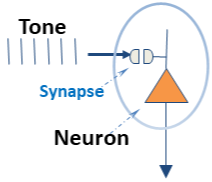

---

### CHALLENGE - Assume the baseline firing rate, i.e., in the absence of fear is **0.5 Hz**. And that the firing rate when fearful is **7 Hz**. Your task is to manipulate the value of the 'input strength' (strength of tone connection) below to find the settings that results in a NO-FEAR state, and the FEAR state.  Report the tone strength values you found for the two cases. 

Running Model!


Number of spikes: 34
Firing rate: 7.556 Hz


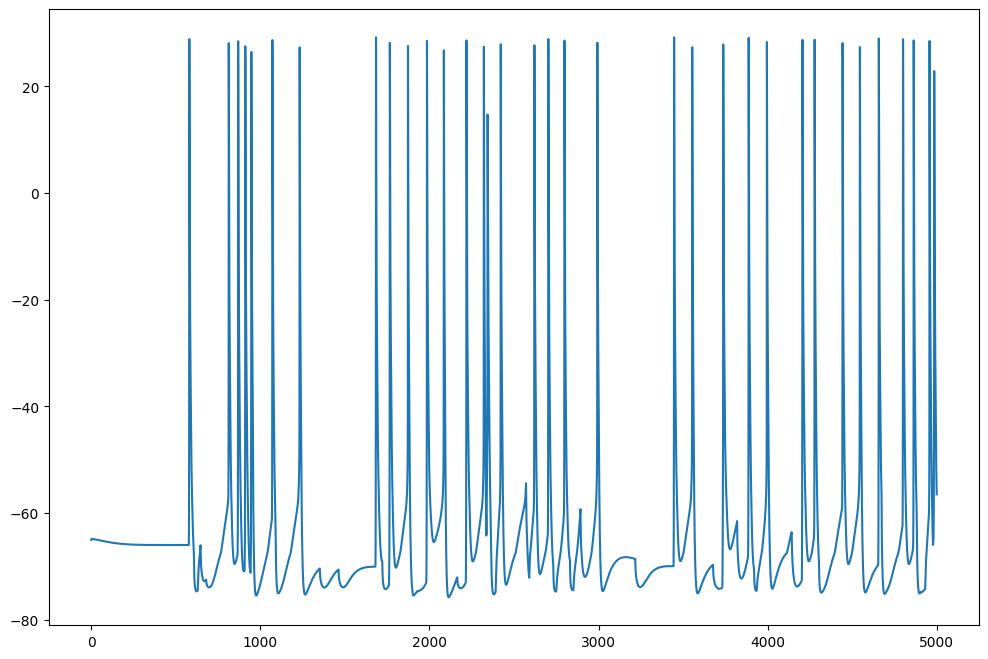

In [4]:
#@title run model
from neuron import h
from neuron.units import ms, mV
import matplotlib.pyplot as plt
import numpy as np
from bmtk.utils.reports.spike_trains import PoissonSpikeGenerator
import ipywidgets as widgets
from IPython.display import display, clear_output

seed = 1234
rng = np.random.default_rng(seed)
np.random.seed(seed)

def generate_poisson_spikes(syn_number, start_time, end_time, hz):
    spikes = PoissonSpikeGenerator(population='spikes')
    spikes.add(node_ids=range(syn_number), firing_rate=hz, times=(start_time, end_time))
    return spikes

def run_model(b):
    clear_output()
    print("Running Model!")
    PN_weight_val = PN_weight_slider.value
    display(controls_box)
    model(PN_weight=PN_weight_val, PV_weight=1)

def model(PN_weight=None, PV_weight=None):
    seed = 1234
    rng = np.random.default_rng(seed)
    np.random.seed(seed)
    h.load_file('stdrun.hoc')
    h.load_file('PN_cells.hoc')  # reads in template
    cell = h.PN_C()  # cell from template file

    h.dt = 0.1  # time step (resolution) of the simulation in ms
    h.tstop = 5000  # how long to run the simulation in ms
    h.v_init = -65  # initial membrane potential in mV

    exc_syn_num = 23  # from amygdala paper
    inh_syn_num = 43  # from amygdala paper

    PN_spikes = generate_poisson_spikes(exc_syn_num, start_time=0.5, end_time=5, hz=10)
    PV_spikes = generate_poisson_spikes(inh_syn_num, start_time=0.5, end_time=5, hz=5)

    for i in range(exc_syn_num):  # for every excitatory synapse(PN2PN):
        conn_exc = h.AMPA_NMDA_STP(cell.dend[0](0.9))  # create syn on apical dendrite
        conn_exc.e = 0
        spikes_exc = PN_spikes.get_times(node_id=i)  # original version of creating spike trains
        v_spikes_exc = h.Vector(spikes_exc)  # make vector based on the spike train
        vec_stim_exc = h.VecStim()  # have vecstim play it
        vec_stim_exc.play(v_spikes_exc)
        nc_exc = h.NetCon(vec_stim_exc, conn_exc, 1, 1, PN_weight)

    for i in range(inh_syn_num):
        conn_inh = h.Exp2Syn(cell.dend[0](0.5))
        conn_inh.e = -75
        spikes_inh = PV_spikes.get_times(node_id=i)
        v_spikes_inh = h.Vector(spikes_inh)
        vec_stim_inh = h.VecStim()
        vec_stim_inh.play(v_spikes_inh)
        nc_exc2 = h.NetCon(vec_stim_inh, conn_inh, 1, 1, PV_weight)

    # Setup recording of spike times
    spike_times = h.Vector()
    spike_detector = h.NetCon(cell.soma[0](0.5)._ref_v, None, sec=cell.soma[0])
    # Set the voltage threshold for spike detection
    spike_detector.threshold = -15  # Set the threshold to -15 mV
    spike_detector.record(spike_times)

    t = h.Vector()  # Vectors are used to record data in the simulation
    Soma_v = h.Vector()

    t.record(h._ref_t)  # dereferences and records data
    Soma_v.record(cell.soma[0](0.5)._ref_v)

    h.finitialize(h.v_init * mV)  # runs sims
    h.continuerun(h.tstop * ms)

    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(12, 8))

    # Convert spike times to a NumPy array
    try:
        spike_times_array = np.array(spike_times)
    except:
        spike_times_array = np.zeros(1)

    # Calculate number of spikes
    num_spikes = len(spike_times_array)

    # Calculate firing rate (spikes per second)
    if h.tstop > 0:
        firing_rate =  round(num_spikes / (4500 / 1000),3)
    else:
        firing_rate = 0.0

    # Print results
    print("Number of spikes:", num_spikes)
    print("Firing rate:", firing_rate, "Hz")

    ax.plot(t, Soma_v)
    plt.show()

# Create sliders
PN_weight_slider = widgets.FloatSlider(value=2.5, min=2.5, max=100.0, step=1, description='Input Strength:',style=dict(description_width='initial'))

# Create Run button
run_button = widgets.Button(description="Run")
run_button.on_click(run_model)

# Arrange widgets using HBox and VBox
slider_box = widgets.VBox([PN_weight_slider])
controls_box = widgets.HBox([slider_box, run_button])

# Display widgets
display(controls_box)
